# **Helper**

In [162]:
!pip install opencv-python numpy paho-mqtt matplotlib

In [163]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json, time, os
import paho.mqtt.client as mqtt

plt.rcParams["figure.figsize"] = (6, 6)

def show(title, img, cmap=None):
    """Display image via matplotlib; accepts BGR or grayscale."""
    plt.figure()
    plt.title(title)
    if img.ndim == 2:
        plt.imshow(img, cmap=cmap or "gray")
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

# **Config**

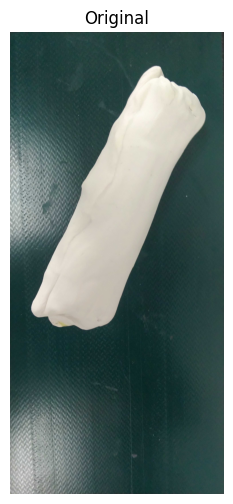

In [164]:
# === User-configurable parameters ===
IMG_PATH = "/home/drasogun/DraSoGun/Work/Fibo/Project/img/img_very_clean.jpg"  # change to your test image

PIXELS_PER_CM = 19.23

# Dough HSV heuristics (white/desaturated + bright)
S_MAX_WHITE = 40
V_MIN_WHITE = 190

# Background hue auto-veto (robust to local background color)
BG_S_MIN = 45
BG_H_BAND = 15

# Area / shape thresholds
MIN_DOUGH_AREA = 1200     # px
MAX_AREA_FRAC = 0.45      # max fraction of image to consider (avoid full-frame blobs)
BOX_FILL_MIN = 0.30       # area/(w*h) minimal (avoid long thin shapes)
MIN_CONTAM_AREA = 60      # contaminant min area px  (increased to avoid tiny texture noise)

# Morphology / processing
KERNEL_SIZE = 5
BH_KERNEL = 9             # black-hat kernel size (odd)
K_SIGMA = 3.0             # threshold t = mu + K_SIGMA * sigma (increased to be more conservative)

# Interior margin (remove border shading/noise)
PIXEL_MARGIN_MIN = 8
MARGIN_FRAC = 0.4         # multiplier of PIXELS_PER_CM for margin_px

# --- NEW: color/intensity checks to reduce false positives ---
DELTA_AB_MIN = 10.0       # Δab threshold; raised to reduce color-noise false positives
DELTA_L_MIN = 18.0        # require this drop in L (interior L - spot L) to accept dark spots on white dough
BH_MEAN_FACTOR = 1.0      # require mean_blackhat >= mu + BH_MEAN_FACTOR * sigma (stricter)
BH_MEAN_MIN = 10.0        # and also >= BH_MEAN_MIN absolute
SOLIDITY_MIN = 0.55       # require area/convex_hull_area >= SOLIDITY_MIN to reject thin/noise

# --- Border and containment tightening ---
BORDER_MARGIN_PX = 12     # pixels from image edge considered as border-touch veto
MIN_INSIDE_RATIO = 0.90   # require at least this fraction of contour area inside safe-zone

# --- Candidate geometry/color constraints (new) ---
CANDIDATE_SOLIDITY_MIN = 0.85   # dough should be fairly solid
MIN_ASPECT_RATIO = 0.35        # min(min(w,h)/max(w,h)) to avoid long thin strips

# Load image
img_path = Path(IMG_PATH)
assert img_path.exists(), f"Image not found: {IMG_PATH}"
img_bgr = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
assert img_bgr is not None, "Failed to read image"
show("Original", img_bgr)

# **Mask**

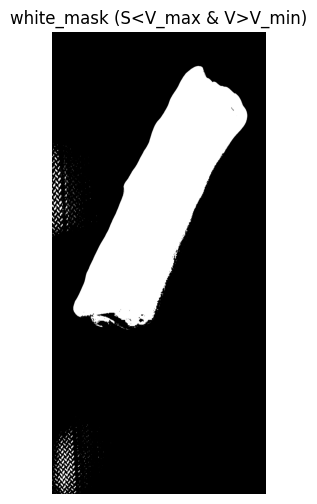

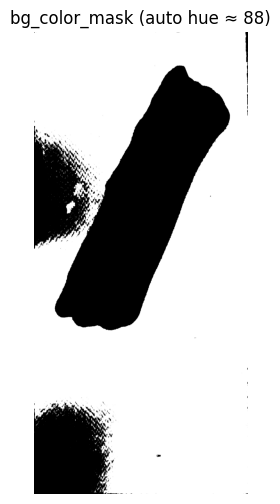

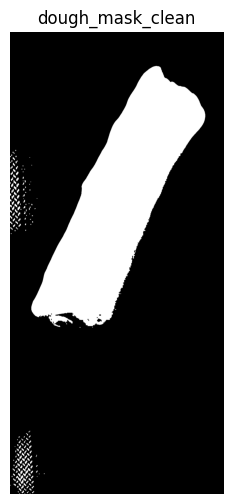

In [165]:
hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
H, S, V = cv2.split(hsv)

# 1) Candidate "dough" by low saturation and high value
white_mask = ((S < S_MAX_WHITE) & (V > V_MIN_WHITE)).astype(np.uint8) * 255
show("white_mask (S<V_max & V>V_min)", white_mask, cmap="gray")

# 2) Estimate background hue from image border and veto similar hue
h_img, w_img = white_mask.shape
edge = max(10, int(min(h_img, w_img) * 0.06))
bg_mask = np.zeros_like(white_mask)
bg_mask[:edge, :] = 255
bg_mask[-edge:, :] = 255
bg_mask[:, :edge] = 255
bg_mask[:, -edge:] = 255
bg_mask = cv2.erode(bg_mask, np.ones((9,9), np.uint8))

bg_h_vals = H[(bg_mask > 0) & (S > BG_S_MIN)]
bg_h = int(np.median(bg_h_vals)) if bg_h_vals.size else 0

# robust circular hue difference
dh = np.abs(H.astype(int) - int(bg_h))
dh = np.minimum(dh, 180 - dh)
bg_color_mask = ((dh <= BG_H_BAND) & (S > BG_S_MIN)).astype(np.uint8) * 255
show(f"bg_color_mask (auto hue ≈ {bg_h})", bg_color_mask, cmap="gray")

# 3) Final dough mask = white mask AND NOT background-color
dough_mask = cv2.bitwise_and(white_mask, cv2.bitwise_not(bg_color_mask))

# 4) Morphological cleanup
kernel = np.ones((KERNEL_SIZE, KERNEL_SIZE), np.uint8)
dough_mask_clean = cv2.morphologyEx(dough_mask, cv2.MORPH_CLOSE, kernel)
dough_mask_clean = cv2.morphologyEx(dough_mask_clean, cv2.MORPH_OPEN, kernel)
show("dough_mask_clean", dough_mask_clean, cmap="gray")

In [166]:
# Helpers: safe-zone and border checks
def build_safe_zone(shape, margin_px):
    h, w = shape
    sz = np.zeros((h, w), np.uint8)
    cv2.rectangle(sz, (margin_px, margin_px), (w - margin_px - 1, h - margin_px - 1), 255, -1)
    return sz

def touches_image_border_mask(mask_bin, erode_px=2):
    """Return True if the (eroded) mask touches the true image border."""
    k = np.ones((3,3), np.uint8)
    m = cv2.erode(mask_bin, k, iterations=max(0, erode_px))
    h, w = m.shape
    return bool(np.any(m[0,:]) or np.any(m[-1,:]) or np.any(m[:,0]) or np.any(m[:,-1]))

def border_checks_for_contour(contour, mask_shape, margin_px):
    """Return (inside_ratio, touch).
    touch True if contour clearly touches/approaches image border (by mask erosion or bbox proximity).
    inside_ratio is fraction of contour area inside the inner safe-zone (1 - margin).
    """
    h, w = mask_shape
    m = np.zeros(mask_shape, np.uint8)
    cv2.drawContours(m, [contour], -1, 255, -1)

    # direct bbox proximity test: if bounding box meets the outer margin, consider touching
    x, y, bw, bh = cv2.boundingRect(contour)
    touch_by_bbox = (x <= margin_px) or (y <= margin_px) or (x + bw >= w - margin_px) or (y + bh >= h - margin_px)

    # eroded mask test (robust to thin connections): erosion amount scales with margin
    erode_px = max(1, min(6, margin_px // 3))
    touch_by_mask = touches_image_border_mask(m, erode_px=erode_px)

    safe = build_safe_zone(mask_shape, margin_px)
    inside = cv2.bitwise_and(m, safe)
    area_all = cv2.countNonZero(m) + 1e-6
    inside_ratio = cv2.countNonZero(inside) / area_all

    touch = bool(touch_by_mask or touch_by_bbox)
    return inside_ratio, touch

# **Find candidate dough**

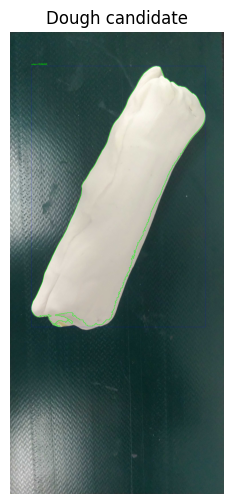

found_dough: 1 reason: ok


In [167]:
h_img, w_img = dough_mask_clean.shape
img_area = h_img * w_img
contours, _ = cv2.findContours(dough_mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

found_dough = False
c_dough = None
reason = "no contour"
chosen_reason = reason
best_score = -1.0

for c in contours:
    area = cv2.contourArea(c)
    if area < MIN_DOUGH_AREA:
        reason = "too small"; continue
    if area > MAX_AREA_FRAC * img_area:
        reason = "too large"; continue
    x, y, w, h = cv2.boundingRect(c)
    box_fill = area / (w * h + 1e-6)
    if box_fill < BOX_FILL_MIN:
        reason = f"box_fill low ({box_fill:.2f})"; continue

    # stricter containment / border checks
    inside_ratio, touch = border_checks_for_contour(c, dough_mask_clean.shape, BORDER_MARGIN_PX)
    if touch:
        reason = f"touches border (bbox/mask)"; continue
    if inside_ratio < MIN_INSIDE_RATIO:
        reason = f"inside_ratio low ({inside_ratio:.2f})"; continue

    # ensure candidate is desaturated & bright as expected for dough
    mask_c = np.zeros_like(dough_mask_clean, dtype=np.uint8)
    cv2.drawContours(mask_c, [c], -1, 255, thickness=cv2.FILLED)
    cnt_pixels = np.count_nonzero(mask_c)
    if cnt_pixels == 0:
        reason = "empty mask"; continue
    mean_S = float(np.mean(S[mask_c > 0]))
    mean_V = float(np.mean(V[mask_c > 0]))
    if not (mean_S <= S_MAX_WHITE and mean_V >= V_MIN_WHITE):
        reason = f"color mismatch (S={mean_S:.1f},V={mean_V:.1f})"; continue

    # geometric checks: avoid long thin strips and require high solidity for dough
    aspect = min(w, h) / (max(w, h) + 1e-6)
    hull = cv2.convexHull(c)
    hull_area = cv2.contourArea(hull) + 1e-6
    solidity = area / hull_area
    if aspect < MIN_ASPECT_RATIO:
        reason = f"aspect low ({aspect:.2f})"; continue
    if solidity < CANDIDATE_SOLIDITY_MIN:
        reason = f"solidity low ({solidity:.2f})"; continue

    # Veto if candidate's color/hue matches estimated background (likely a bright background strip)
    mean_H = float(np.mean(H[mask_c > 0]))
    dhc = abs(int(mean_H) - int(bg_h))
    dhc = min(dhc, 180 - dhc)
    if (mean_S > BG_S_MIN) and (dhc <= BG_H_BAND):
        reason = f"bg hue match (dh={dhc:.0f}, mean_S={mean_S:.0f})"; continue

    # score by area (prefer largest eligible contour)
    score = area
    if score > best_score:
        best_score = score
        c_dough = c
        found_dough = True
        chosen_reason = "ok"

# Visualize final choice and report chosen_reason (avoid overwritten reason from later skips)
vis = img_bgr.copy()
if found_dough and c_dough is not None:
    x, y, w, h = cv2.boundingRect(c_dough)
    cv2.drawContours(vis, [c_dough], -1, (0,255,0), 2)
    cv2.rectangle(vis, (x,y), (x+w,y+h), (255,0,0), 1)
    cv2.putText(vis, f"area={cv2.contourArea(c_dough):.0f}", (x, max(20,y-10)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,200,0), 2)
    reason_to_print = chosen_reason
else:
    reason_to_print = reason
    cv2.putText(vis, f"NO DOUGH ({reason_to_print})", (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,255), 2)

show("Dough candidate", vis)
print("found_dough:", int(found_dough), "reason:", reason_to_print)

# **Interior (distance transform) and black-hat**

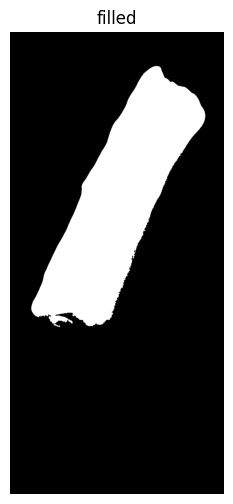

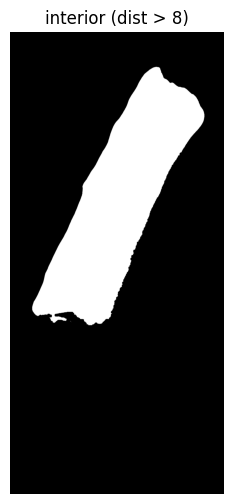

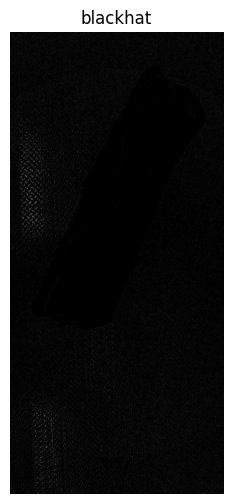

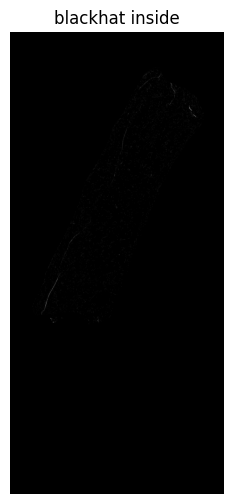

ref_ab (median a,b in interior): [128. 135.] ref_L: 215.0


In [168]:
if not found_dough:
    raise SystemExit("No suitable dough found. Adjust thresholds or use a different image.")

filled = np.zeros_like(dough_mask_clean)
cv2.drawContours(filled, [c_dough], -1, 255, thickness=cv2.FILLED)

margin_px = max(PIXEL_MARGIN_MIN, int(MARGIN_FRAC * PIXELS_PER_CM))
dist = cv2.distanceTransform(filled, cv2.DIST_L2, 3)
interior = np.uint8((dist > margin_px) * 255)

lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
L = lab[:, :, 0]
L_blur = cv2.GaussianBlur(L, (5,5), 0)
kernel_bh = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (BH_KERNEL, BH_KERNEL))
blackhat = cv2.morphologyEx(L_blur, cv2.MORPH_BLACKHAT, kernel_bh)
bh_in = cv2.bitwise_and(blackhat, blackhat, mask=interior)

# --- compute robust reference in ab-plane from interior (used to check spot color difference) ---
lab_ab = lab[..., 1:3].astype(np.float32)
mask_core = (interior > 0)
if np.count_nonzero(mask_core) > 0:
    ref_ab = np.median(lab_ab[mask_core], axis=0)
    ref_L = float(np.median(L[mask_core]))
else:
    ref_ab = np.array([0.0, 0.0], dtype=np.float32)
    ref_L = 128.0

show("filled", filled, cmap="gray")
show(f"interior (dist > {margin_px})", interior, cmap="gray")
show("blackhat", blackhat, cmap="gray")
show("blackhat inside", bh_in, cmap="gray")
print("ref_ab (median a,b in interior):", ref_ab, "ref_L:", ref_L)

# **Threshold and cleanup**

mu=0.15, sigma=0.48, t=1.60


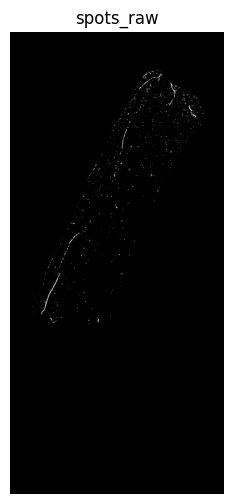

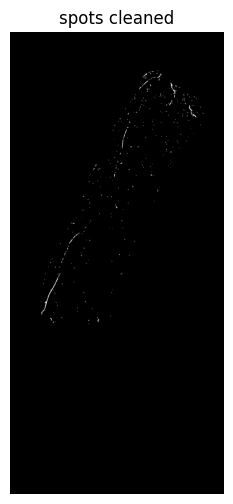

In [169]:
vals = bh_in[interior > 0]
mu, sigma = (float(vals.mean()), float(vals.std())) if vals.size > 0 else (0.0, 0.0)
t = mu + K_SIGMA * sigma
_, spots_raw = cv2.threshold(bh_in, t, 255, cv2.THRESH_BINARY)
spots = cv2.morphologyEx(spots_raw, cv2.MORPH_OPEN, np.ones((3,3), np.uint8), iterations=1)
spots = cv2.morphologyEx(spots, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8), iterations=1)
print(f"mu={mu:.2f}, sigma={sigma:.2f}, t={t:.2f}")
show("spots_raw", spots_raw, cmap="gray")
show("spots cleaned", spots, cmap="gray")

# **Find contaminants**

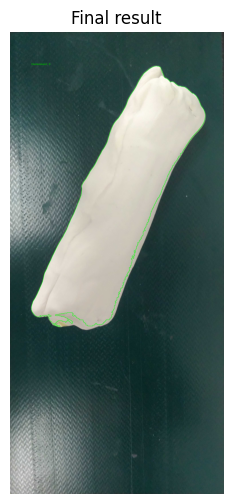

contaminant_status: 0


In [170]:
contours_contam, _ = cv2.findContours(spots, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
out = img_bgr.copy()
contaminant_status = 0

# For per-spot checks we use lab_ab, ref_ab, L, ref_L, and bh_in computed earlier
for cc in contours_contam:
    area = cv2.contourArea(cc)
    if area < MIN_CONTAM_AREA:
        continue
    x, y, w, h = cv2.boundingRect(cc)
    per = cv2.arcLength(cc, True) + 1e-6
    circ = 4 * np.pi * area / (per * per)
    extent = area / (w * h + 1e-6)

    # center for interior-distance check
    cx, cy = np.mean(cc.reshape(-1, 2), axis=0).astype(int)
    if dist[cy, cx] < margin_px:
        continue

    # shape-based rejection (long thin lines / small round noise)
    # reject obviously thin/low-circularity noise
    if extent < 0.12 and circ < 0.18:
        continue

    # solidity check (area / convex-hull-area) to remove spiky thin artifacts
    hull = cv2.convexHull(cc)
    hull_area = cv2.contourArea(hull) + 1e-6
    solidity = area / hull_area
    if solidity < SOLIDITY_MIN:
        continue

    # --- per-spot color check (Δab) and new ΔL check ---
    mask_c = np.zeros_like(spots, dtype=np.uint8)
    cv2.drawContours(mask_c, [cc], -1, 255, thickness=cv2.FILLED)
    spot_pixels = (mask_c > 0)
    if np.count_nonzero(spot_pixels) == 0:
        continue
    mean_ab_spot = np.mean(lab_ab[spot_pixels], axis=0)
    delta_ab = float(np.linalg.norm(mean_ab_spot - ref_ab))
    mean_L_spot = float(np.mean(L[spot_pixels]))
    delta_L = float(ref_L - mean_L_spot)  # positive when spot is darker than interior

    # --- compute intensity + combined decision ---
    mean_dark = float(cv2.mean(bh_in, mask=mask_c)[0])
    intensity_threshold = max(BH_MEAN_MIN, mu + BH_MEAN_FACTOR * sigma)

    # Build 3-cue decision: color (Δab), lightness drop (ΔL), dark intensity (bh)
    cues = 0
    if delta_ab >= DELTA_AB_MIN:
        cues += 1
    if delta_L >= DELTA_L_MIN:
        cues += 1
    if mean_dark >= intensity_threshold:
        cues += 1

    # require at least two strong cues to reduce single-cue false positives
    if cues < 2:
        continue

    # Passed all checks → mark contaminant
    contaminant_status = 1
    cv2.rectangle(out, (x,y), (x+w, y+h), (0,0,255), 2)
    cv2.putText(out, f"Contaminant (Δab={delta_ab:.1f}, ΔL={delta_L:.1f}, dark={mean_dark:.1f}, sol={solidity:.2f})", (x, y-8), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 2)
    break

cv2.drawContours(out, [c_dough], -1, (0,255,0), 2)
x_b, y_b, w_b, h_b = cv2.boundingRect(c_dough)
msg = f"Contaminant: {contaminant_status}"
cv2.putText(out, msg, (x_b, y_b-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255) if contaminant_status else (0,180,0), 2)
show("Final result", out)
print("contaminant_status:", contaminant_status)